In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.typing as npt
import requests
import ujson as json
import QuantLib as ql
import warnings
from scipy.optimize import fmin
from scipy.stats import zscore
from datetime import datetime 
from typing import List, Annotated, Literal 

from scripts.fetch_treasuries import get_historical_treasury_auctions

import nest_asyncio
nest_asyncio.apply()

sns.set(style="whitegrid", palette="dark")
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
# auctions_df = get_historical_treasury_auctions(xlsx_path="data/Histroical_Treasury_Auctions.xlsx", return_df=True)
auctions_df = pd.read_excel("data/Histroical_Treasury_Auctions.xlsx")
auctions_df

,record_date,cusip,security_type,security_term,auction_date,issue_date,maturity_date,price_per100,accrued_int_per100,accrued_int_per1000,...,total_tendered,treas_retail_accepted,treas_retail_tenders_accepted,unadj_accrued_int_per1000,unadj_price,xml_filenm_announcemt,xml_filenm_comp_results,inflation_index_security,tint_cusip_1,tint_cusip_2
0,1979-11-15,912827KC5,Note,10-Year,1979-10-31,1979-11-15,1989-11-15,NaN,NaN,0.00000,...,3.818000e+09,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN
1,1979-11-15,912810CK2,Bond,30-Year,1979-11-01,1979-11-15,2009-11-15,NaN,NaN,0.00000,...,3.594000e+09,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN
2,1980-01-03,9127933Y0,Bill,13-Week,1979-12-28,1980-01-03,1980-04-03,NaN,NaN,NaN,...,5.371540e+09,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN
3,1980-01-03,9127934U7,Bill,26-Week,1979-12-28,1980-01-03,1980-07-03,NaN,NaN,NaN,...,5.954350e+09,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN
4,1980-01-08,9127935W2,Bill,52-Week,1980-01-02,1980-01-08,1981-01-02,NaN,NaN,NaN,...,6.329685e+09,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10114,2024-06-13,912797LN5,Bill,52-Week,2024-06-11,2024-06-13,2025-06-12,NaN,NaN,NaN,...,NaN,NaN,Yes,NaN,NaN,A_20240606_3.xml,NaN,No,NaN,NaN
10115,2024-06-13,912797JT5,CMB,42-Day,2024-06-11,2024-06-13,2024-07-25,NaN,NaN,NaN,...,NaN,NaN,No,NaN,NaN,A_20240606_6.xml,NaN,No,NaN,NaN
10116,2024-06-17,912810UA4,Bond,29-Year 11-Month,2024-06-13,2024-06-17,2054-05-15,NaN,NaN,4.14742,...,NaN,NaN,Yes,NaN,NaN,A_20240606_1.xml,NaN,No,NaN,NaN
10117,2024-06-17,91282CKV2,Note,3-Year,2024-06-10,2024-06-17,2027-06-15,99.905415,NaN,0.25273,...,1.429916e+11,83282700.0,Yes,NaN,NaN,A_20240606_4.xml,R_20240610_3.xml,No,912834XR4,NaN


In [147]:
TreasurySecurityTerm = Literal[
    "8-Week",
    "119-Day",
    "17-Week",
    "154-Day",
    "26-Week",
    "52-Week",
    "2-Year",
    "3-Year",
    "5-Year",
    "7-Year",
    "10-Year",
    "20-Year",
    "30-Year",
]

TreasurySecurityType = Literal[
    "Bill", "Bond", "CMB", "FRN Note", "Note", "TIPS Bond", "TIPS Note"
]

PlotType = Literal[
    "price_per100",
    "adj_price",
    "avg_med_discnt_rate",	
    "avg_med_investment_rate",
    "avg_med_price",
    "avg_med_discnt_margin"
    "avg_med_yield",
    "bid_to_cover_ratio",
    "allocation_pctage",
    "comp_accepted",
    "comp_tendered",
    "comp_tenders_accepted",
    "direct_bidder_accepted",
    "direct_bidder_tendered",
    "high_discnt_rate",
    "high_investment_rate",
    "high_price",
    "high_discnt_margin",
    "high_yield",
    "int_rate",
    "low_discnt_rate",
    "low_investment_rate",
    "low_price",
    "low_discnt_margin",
    "low_yield",
    "max_comp_award",
    "max_noncomp_award",
    "max_single_bid",
    "noncomp_accepted",
    "offering_am",
    "primary_dealer_accepted",
    "primary_dealer_tendered",
    "soma_accepted",
    "soma_holding",
    "soma_tendered",
    "total_accepted",
    "total_tendered",
    "treas_retail_accepted",
    
    ### calculated
    "price_tail",
    "snap_price", # intraday data from velocity
    "recent_price_performance", # treasurydirect data
]   

In [167]:
def filter_auctions(
    auctions_df: pd.DataFrame,
    security_type: TreasurySecurityType,
    security_term: TreasurySecurityTerm,
    date_range: Annotated[List[datetime], 2],
) -> pd.DataFrame:
    auctions_df = auctions_df.copy()
    auctions_df["auction_date"] = pd.to_datetime(auctions_df["auction_date"])
    auctions_df = auctions_df[
        (auctions_df["auction_date"] >= date_range[0])
        & (auctions_df["auction_date"] <= date_range[1])
    ]
    auctions_df = auctions_df[
        (auctions_df["original_security_term"] == security_term)
    ]
    auctions_df = auctions_df[
        (auctions_df["security_type"] == security_type)
    ]
    return auctions_df

In [168]:
three_year_auctions_df = filter_auctions(
    auctions_df=auctions_df,
    security_type="Note",
    security_term="3-Year",
    date_range=[datetime(2016, 1, 1), datetime(2024, 6, 10)],
)
three_year_auctions_df

,record_date,cusip,security_type,security_term,auction_date,issue_date,maturity_date,price_per100,accrued_int_per100,accrued_int_per1000,...,total_tendered,treas_retail_accepted,treas_retail_tenders_accepted,unadj_accrued_int_per1000,unadj_price,xml_filenm_announcemt,xml_filenm_comp_results,inflation_index_security,tint_cusip_1,tint_cusip_2
7021,2016-01-15,912828N63,Note,3-Year,2016-01-12,2016-01-15,2019-01-15,99.855973,NaN,NaN,...,7.066258e+10,23334800.0,Yes,NaN,NaN,A_20160107_2.xml,R_20160112_2.xml,No,NaN,NaN
7042,2016-02-16,912828P53,Note,3-Year,2016-02-09,2016-02-16,2019-02-15,99.722361,NaN,0.02060,...,6.769723e+10,34615800.0,Yes,NaN,NaN,A_20160203_3.xml,R_20160209_2.xml,No,NaN,NaN
7063,2016-03-15,912828P95,Note,3-Year,2016-03-08,2016-03-15,2019-03-15,99.885098,NaN,NaN,...,6.503805e+10,28954400.0,Yes,NaN,NaN,A_20160303_3.xml,R_20160308_2.xml,No,NaN,NaN
7087,2016-04-15,912828Q52,Note,3-Year,2016-04-12,2016-04-15,2019-04-15,99.955693,NaN,NaN,...,6.547080e+10,33821500.0,Yes,NaN,NaN,A_20160407_1.xml,R_20160412_2.xml,No,NaN,NaN
7108,2016-05-16,912828R44,Note,3-Year,2016-05-10,2016-05-16,2019-05-15,99.999989,NaN,0.02378,...,7.583080e+10,44837300.0,Yes,NaN,NaN,A_20160504_2.xml,R_20160510_2.xml,No,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9972,2024-02-15,91282CKA8,Note,3-Year,2024-02-06,2024-02-15,2027-02-15,99.877119,NaN,NaN,...,1.433450e+11,90984200.0,Yes,NaN,NaN,A_20240131_1.xml,R_20240206_2.xml,No,NaN,NaN
10007,2024-03-15,91282CKE0,Note,3-Year,2024-03-11,2024-03-15,2027-03-15,99.983268,NaN,NaN,...,1.458164e+11,87078100.0,Yes,NaN,NaN,A_20240307_3.xml,R_20240311_3.xml,No,912834XK9,NaN
10043,2024-04-15,91282CKJ9,Note,3-Year,2024-04-09,2024-04-15,2027-04-15,99.866800,NaN,NaN,...,1.458058e+11,84735200.0,Yes,NaN,NaN,A_20240404_3.xml,R_20240409_2.xml,No,912834XM5,NaN
10078,2024-05-15,91282CKR1,Note,3-Year,2024-05-07,2024-05-15,2027-05-15,99.708904,NaN,NaN,...,1.599304e+11,118749400.0,Yes,NaN,NaN,A_20240501_1.xml,R_20240507_2.xml,No,NaN,NaN


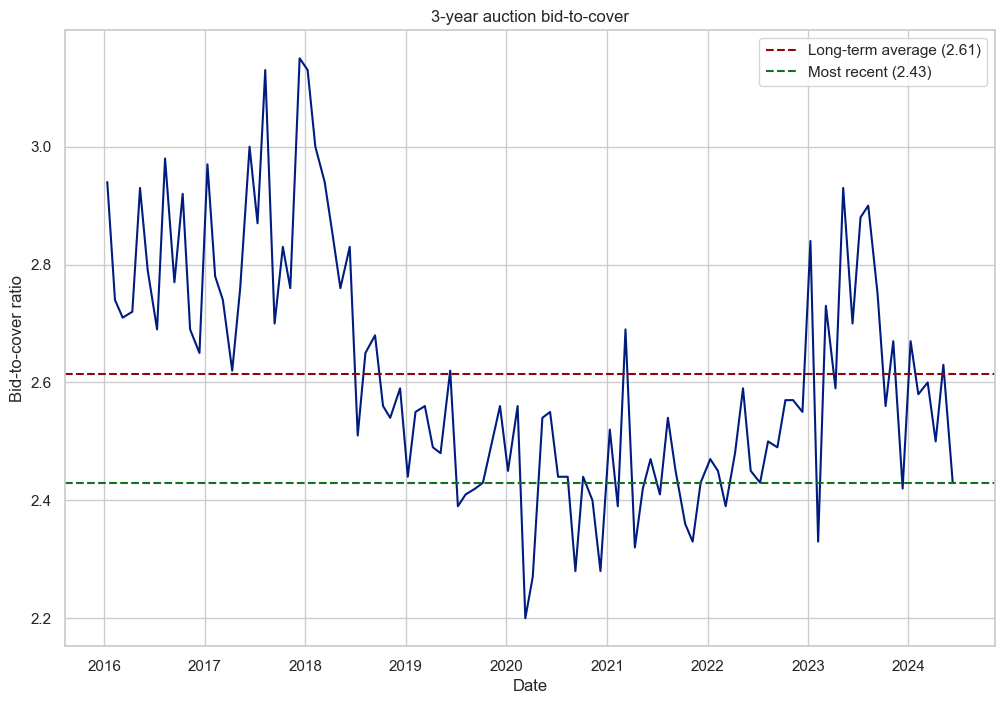

In [171]:
long_term_avg = three_year_auctions_df["bid_to_cover_ratio"].mean()
most_recent_value = three_year_auctions_df["bid_to_cover_ratio"].iloc[-1]

plt.figure(figsize=(12, 8))
plt.plot(
    three_year_auctions_df["auction_date"], three_year_auctions_df["bid_to_cover_ratio"]
)
plt.axhline(
    long_term_avg,
    color="r",
    linestyle="--",
    label=f"Long-term average ({long_term_avg:.2f})",
)
plt.axhline(
    most_recent_value,
    color="g",
    linestyle="--",
    label=f"Most recent ({most_recent_value:.2f})",
)
plt.xlabel("Date")
plt.ylabel("Bid-to-cover ratio")
plt.title("3-year auction bid-to-cover")
plt.legend()

plt.grid(True)
plt.show()

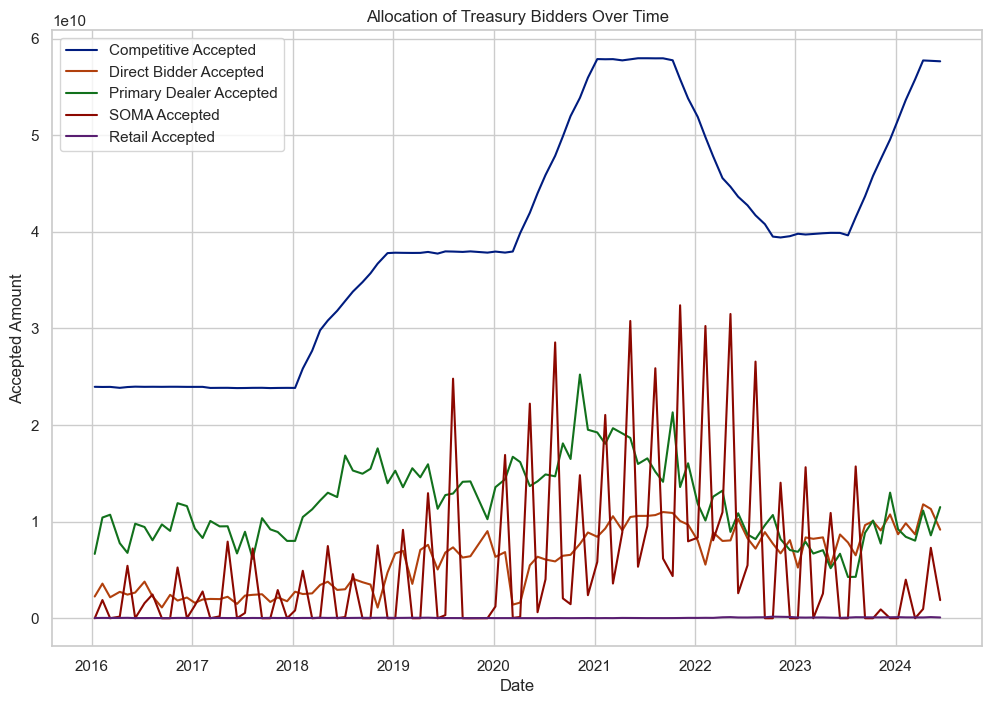

In [179]:
plt.figure(figsize=(12, 8))

plt.plot(
    three_year_auctions_df["auction_date"],
    three_year_auctions_df["comp_accepted"],
    linestyle="-",
    label="Competitive Accepted",
)
plt.plot(
    three_year_auctions_df["auction_date"],
    three_year_auctions_df["direct_bidder_accepted"],
    linestyle="-",
    label="Direct Bidder Accepted",
)
plt.plot(
    three_year_auctions_df["auction_date"],
    three_year_auctions_df["primary_dealer_accepted"],
    linestyle="-",
    label="Primary Dealer Accepted",
)
plt.plot(
    three_year_auctions_df["auction_date"],
    three_year_auctions_df["soma_accepted"],
    linestyle="-",
    label="SOMA Accepted",
)
plt.plot(
    three_year_auctions_df["auction_date"],
    three_year_auctions_df["treas_retail_accepted"],
    linestyle="-",
    label="Retail Accepted",
)

plt.xlabel("Date")
plt.ylabel("Accepted Amount")
plt.title("Allocation of Treasury Bidders Over Time")
plt.legend()

plt.grid(True)
plt.show()